### Setup

In [43]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
import torchvision
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

# Latent dimensions
latent_dim = 10
# Training iterations
iter_max = 50
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [44]:
def get_mnist_data(device, batch_size):
    preprocess = torchvision.transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=True, download=True, transform=preprocess), batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=False, download=True, transform=preprocess), batch_size=batch_size, shuffle=True, num_workers=2)


    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)
    # print(test_loader.dataset.test_data.size())

    # return train_loader, (X_test, y_test)
    return train_loader, test_loader 

train_loader, test_loader = get_mnist_data(device, batch_size)
train_loader

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


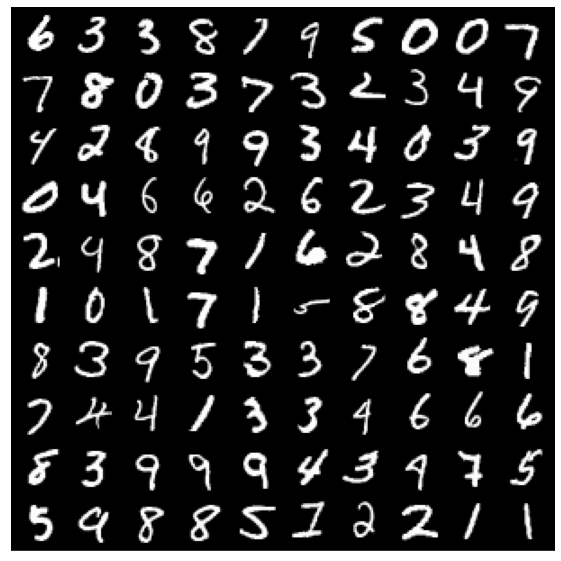

In [217]:
from matplotlib import pyplot as plt

def imshow(img, fig_size = 10):
    npimg = img.numpy()
    # print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(fig_size, fig_size))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(npimg)
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images, nrow = 10))

### Utility Functions

In [98]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    std = torch.exp(0.5 * torch.log(v))
    eps = torch.randn_like(std)
    z = m + std*eps

    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl


def one_hot(y, y_dim): 
    targets = torch.zeros(y.size(0), y_dim)
    for i, label in enumerate(y):
        targets[i, label] = 1
    return torch.autograd.Variable(targets)

### Base Models

In [47]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat([x, y], dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### CVAE Model

In [214]:
class CVAE(nn.Module):
    def __init__(self, name = 'vae', z_dim = 2, y_dim = 0):
        super().__init__()
        self.name = name
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.enc = Encoder(self.z_dim, self.y_dim)
        self.dec = Decoder(self.z_dim, self.y_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)


    def loss(self, x, y):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """

        #Forward pass
        m, v = self.enc.encode(x, y)
        z = sample_gaussian(m, v)
        x_r = self.dec.decode(z, y)

        #KL
        kl = -0.5 * torch.sum(1 + torch.log(v) - m.pow(2) - torch.log(v).exp())

        #Rec
        rec = torch.sum(log_bernoulli_with_logits(x, x_r))

        nelbo = 0.01 * (kl + rec)
        return nelbo, kl, rec

# Training:

In [149]:
y_d = train_loader.dataset.train_labels.unique().size(0)
cvae = CVAE(z_dim = latent_dim, y_dim = y_d).to(device)

optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

train_loss = []
kl_arr = []
rec_arr = []
for i in tqdm(range(iter_max)):
  cvae.train()
  for batch_idx, (xu, yu) in enumerate(train_loader):
      xu = xu.to(device)
      yu = one_hot(yu, y_d).to(device)
      optimizer.zero_grad()

      loss, kl, rec = cvae.loss(xu.view(-1, 784), yu)
      loss.backward()
      optimizer.step()

  print('Train set loss:{}'.format(loss))
  train_loss = np.append(train_loss ,loss.item())
  kl_arr = np.append(kl_arr , kl.item())
  rec_arr = np.append(rec_arr , rec.item())

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  2%|▏         | 1/50 [00:17<14:38, 17.93s/it]

Train set loss:123.65178680419922


  4%|▍         | 2/50 [00:36<14:45, 18.45s/it]

Train set loss:110.78921508789062


  6%|▌         | 3/50 [00:58<15:31, 19.82s/it]

Train set loss:113.51183319091797


  8%|▊         | 4/50 [01:15<14:33, 18.99s/it]

Train set loss:107.49883270263672


 10%|█         | 5/50 [01:33<13:51, 18.47s/it]

Train set loss:104.12699890136719


 12%|█▏        | 6/50 [01:51<13:20, 18.19s/it]

Train set loss:111.99488830566406


 14%|█▍        | 7/50 [02:08<12:54, 18.02s/it]

Train set loss:101.4623031616211


 16%|█▌        | 8/50 [02:26<12:32, 17.92s/it]

Train set loss:104.61298370361328


 18%|█▊        | 9/50 [02:44<12:11, 17.83s/it]

Train set loss:106.44691467285156


 20%|██        | 10/50 [03:01<11:52, 17.80s/it]

Train set loss:107.36714935302734


 22%|██▏       | 11/50 [03:19<11:32, 17.77s/it]

Train set loss:98.67545318603516


 24%|██▍       | 12/50 [03:38<11:29, 18.14s/it]

Train set loss:100.24038696289062


 26%|██▌       | 13/50 [03:57<11:19, 18.36s/it]

Train set loss:95.10806274414062


 28%|██▊       | 14/50 [04:15<10:54, 18.18s/it]

Train set loss:98.54248809814453


 30%|███       | 15/50 [04:32<10:30, 18.02s/it]

Train set loss:99.24232482910156


 32%|███▏      | 16/50 [04:50<10:12, 18.03s/it]

Train set loss:100.72113037109375


 34%|███▍      | 17/50 [05:10<10:09, 18.48s/it]

Train set loss:96.7144546508789


 36%|███▌      | 18/50 [05:28<09:43, 18.25s/it]

Train set loss:94.80084991455078


 38%|███▊      | 19/50 [05:45<09:20, 18.09s/it]

Train set loss:95.72284698486328


 40%|████      | 20/50 [06:03<08:58, 17.95s/it]

Train set loss:95.22711944580078


 42%|████▏     | 21/50 [06:22<08:48, 18.22s/it]

Train set loss:94.92259216308594


 44%|████▍     | 22/50 [06:41<08:37, 18.48s/it]

Train set loss:100.47716522216797


 46%|████▌     | 23/50 [06:59<08:13, 18.28s/it]

Train set loss:99.34624481201172


 48%|████▊     | 24/50 [07:16<07:51, 18.14s/it]

Train set loss:100.33466339111328


 50%|█████     | 25/50 [07:34<07:32, 18.10s/it]

Train set loss:96.8819351196289


 52%|█████▏    | 26/50 [07:52<07:11, 17.99s/it]

Train set loss:94.1356430053711


 54%|█████▍    | 27/50 [08:10<06:53, 17.98s/it]

Train set loss:96.62088012695312


 56%|█████▌    | 28/50 [08:28<06:36, 18.01s/it]

Train set loss:96.33304595947266


 58%|█████▊    | 29/50 [08:46<06:16, 17.95s/it]

Train set loss:98.59867095947266


 60%|██████    | 30/50 [09:07<06:16, 18.80s/it]

Train set loss:100.44026184082031


 62%|██████▏   | 31/50 [09:26<06:00, 18.98s/it]

Train set loss:94.5035171508789


 64%|██████▍   | 32/50 [09:44<05:34, 18.61s/it]

Train set loss:90.71834564208984


 66%|██████▌   | 33/50 [10:02<05:11, 18.32s/it]

Train set loss:95.35398864746094


 68%|██████▊   | 34/50 [10:20<04:51, 18.22s/it]

Train set loss:95.09608459472656


 70%|███████   | 35/50 [10:38<04:31, 18.11s/it]

Train set loss:92.29691314697266


 72%|███████▏  | 36/50 [10:56<04:14, 18.17s/it]

Train set loss:94.7869873046875


 74%|███████▍  | 37/50 [11:14<03:55, 18.09s/it]

Train set loss:96.9380874633789


 76%|███████▌  | 38/50 [11:32<03:36, 18.05s/it]

Train set loss:93.76228332519531


 78%|███████▊  | 39/50 [11:49<03:17, 17.95s/it]

Train set loss:94.23204040527344


 80%|████████  | 40/50 [12:07<02:59, 17.97s/it]

Train set loss:93.71056365966797


 82%|████████▏ | 41/50 [12:25<02:41, 17.93s/it]

Train set loss:97.55552673339844


 84%|████████▍ | 42/50 [12:44<02:25, 18.20s/it]

Train set loss:93.33296966552734


 86%|████████▌ | 43/50 [13:02<02:06, 18.10s/it]

Train set loss:90.2239990234375


 88%|████████▊ | 44/50 [13:20<01:48, 18.02s/it]

Train set loss:93.78851318359375


 90%|█████████ | 45/50 [13:38<01:29, 17.99s/it]

Train set loss:93.2796630859375


 92%|█████████▏| 46/50 [13:57<01:13, 18.29s/it]

Train set loss:94.03752899169922


 94%|█████████▍| 47/50 [14:17<00:56, 18.92s/it]

Train set loss:93.0265121459961


 96%|█████████▌| 48/50 [14:35<00:37, 18.63s/it]

Train set loss:88.11544036865234


 98%|█████████▊| 49/50 [14:53<00:18, 18.49s/it]

Train set loss:99.35781860351562


100%|██████████| 50/50 [15:11<00:00, 18.23s/it]

Train set loss:98.53298950195312


# Train Statistics:

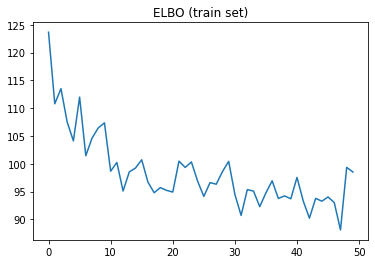

In [150]:
plt.plot(train_loss)
plt.title('ELBO (train set)')
plt.show()

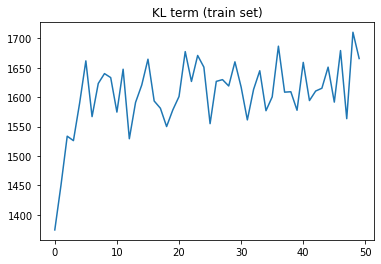

In [151]:
plt.plot(kl_arr)
plt.title('KL term (train set)')
plt.show()

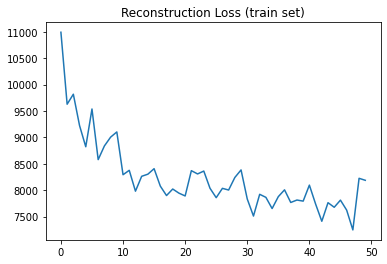

In [152]:
plt.plot(rec_arr)
plt.title('Reconstruction Loss (train set)')
plt.show()

# cpred function:

In [244]:
def cpred(label, fig_size=5, sample_number = 3):

  with torch.no_grad():
      y = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
      y[0, label] = 1
      y1 = y
      for i in range(sample_number - 1 ):
        y = torch.cat([y, y1])
      
      z = torch.randn(sample_number, 10).to(device)
      x_g = cvae.dec.decode(z, y)

      imshow(torchvision.utils.make_grid(x_g.view(sample_number, 1, 28, 28), nrow = 10), fig_size= fig_size)

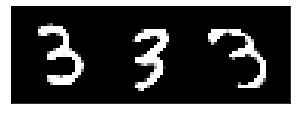

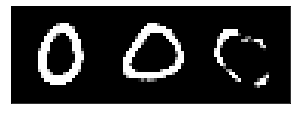

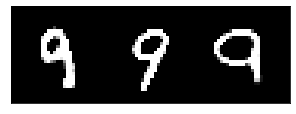

In [259]:
cpred(3, fig_size = 5)
cpred(0, fig_size = 5)
cpred(9, fig_size = 5)